In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import statistics
from IPython.display import HTML
from IPython.display import display
import torchdata
from ipywidgets import IntProgress

import tonic
import tonic.transforms as transforms  # instead of torchdata.transfroms
from tonic import DiskCachedDataset

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

import snntorch as snn
from snntorch import surrogate
import snntorch.spikeplot as splt
from snntorch import functional as SF
from snntorch import utils

C:\Users\vciup\anaconda3\envs\snn\Lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


### ST-MNIST Dataset

In [5]:
# retrieve the ST-MNIST dataset
# after downloading the dataset zip, the archive should be placed inside 
# the STMNIST folder in the root directory of the project
dataset = tonic.prototype.datasets.STMNIST(root='./', keep_compressed=False, shuffle=False)

In [10]:
sensor_size = tonic.prototype.datasets.STMNIST.sensor_size
sensor_size = tuple(sensor_size.values())

# transform the dataset to a matrix of frames
frame_transform = transforms.Compose([transforms.ToFrame(sensor_size=sensor_size, time_window=20000)])

In [13]:
def transform_STMNIST(dataset, transform):
    # this will process the dataset, split it and transform the events into frames
    
    # split the dataset into training and testing (80% training, 20% testing)
    # we will not include the validation set in this example, since we have a small dataset
    train_size = 5562
    test_size = 1391
    
    train_bar = IntProgress(min=0, max=train_size, description='Transforming training set')
    test_bar = IntProgress(min=0, max=test_size, description='Transforming testing set')
    
    train_set = []
    test_set = []
    
    print('Transforming training set')
    display(train_bar)
    for _ in range(train_size):
        events, target = next(iter(dataset))
        events = transform(events)
        train_set.append((events, target))
        train_bar.value += 1
    print('Transforming testing set')
    display(test_bar)
    for _ in range(test_size):
        events, target = next(iter(dataset))
        events = transform(events)
        test_set.append((events, target))
        test_bar.value += 1

    return train_set, test_set

train_set, test_set = transform_STMNIST(dataset, frame_transform)

Transforming training set


IntProgress(value=0, description='Transforming training set', max=5562)

Transforming testing set


IntProgress(value=0, description='Transforming testing set', max=1391)

In [14]:
# create the dataloader
dataloader = DataLoader(train_set, batch_size=32, shuffle=True)

# prevent the variations in the lengths of the event recordings
transform = tonic.transforms.Compose([torch.from_numpy])

cached_train_set = DiskCachedDataset(train_set, transform=transform, cache_path='./cache/stmnist/train')
cached_test_set = DiskCachedDataset(test_set, cache_path='./cache/stmnist/test')

train_loader = DataLoader(cached_train_set, batch_size=32, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(cached_test_set, batch_size=32, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=False)

### CSNN Model

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters for the SNN
beta = 0.95

# same architecture as in the tutorial and the paper
csnn = nn.Sequential(
    nn.Conv2d(2, 32, kernel_size=4),
    snn.Leaky(beta=beta, init_hidden=True),
    nn.Conv2d(32, 64, kernel_size=3),
    snn.Leaky(beta=beta, init_hidden=True),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 2 * 2, 10),
    snn.Leaky(beta=beta, init_hidden=True, output=True)
).to(device)

optimizer = torch.optim.Adam(csnn.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [19]:
def forward_pass(network, data):
    spk_rec = []
    utils.reset(network)  # resets hidden states for all LIF neurons in the network

    for step in range(data.size(0)):  # data.size(0) = number of time steps
        spk_out, mem_out = network(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

### Training

In [20]:
num_epochs = 50

loss_hist = []
train_acc_hist = []

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        csnn.train()
        spk_rec = forward_pass(csnn, data)
        loss_val = loss_fn(spk_rec, targets)

        # gradient calculation and weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # store loss history for future plotting
        loss_hist.append(loss_val.item())

        # print loss every 10 iterations
        if i%10 == 0:
            print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        # calculate accuracy rate and then append it to accuracy history
        acc = SF.accuracy_rate(spk_rec, targets)
        train_acc_hist.append(acc)

        # print accuracy every 10 iterations
        if i%10 == 0:
            print(f"Accuracy: {acc * 100:.2f}%\n")

Epoch 0, Iteration 0 
Train Loss: 8.76
Accuracy: 12.50%

Epoch 0, Iteration 10 
Train Loss: 8.88
Accuracy: 12.50%

Epoch 0, Iteration 20 
Train Loss: 5.12
Accuracy: 9.38%

Epoch 0, Iteration 30 
Train Loss: 3.44
Accuracy: 9.38%

Epoch 0, Iteration 40 
Train Loss: 3.31
Accuracy: 6.25%

Epoch 0, Iteration 50 
Train Loss: 2.99
Accuracy: 15.62%

Epoch 0, Iteration 60 
Train Loss: 3.30
Accuracy: 9.38%

Epoch 0, Iteration 70 
Train Loss: 3.14
Accuracy: 9.38%

Epoch 0, Iteration 80 
Train Loss: 2.88
Accuracy: 15.62%

Epoch 0, Iteration 90 
Train Loss: 2.97
Accuracy: 3.12%

Epoch 0, Iteration 100 
Train Loss: 3.47
Accuracy: 6.25%

Epoch 0, Iteration 110 
Train Loss: 3.23
Accuracy: 9.38%

Epoch 0, Iteration 120 
Train Loss: 3.04
Accuracy: 9.38%

Epoch 0, Iteration 130 
Train Loss: 2.94
Accuracy: 25.00%

Epoch 0, Iteration 140 
Train Loss: 2.99
Accuracy: 37.50%

Epoch 0, Iteration 150 
Train Loss: 3.00
Accuracy: 31.25%

Epoch 0, Iteration 160 
Train Loss: 2.63
Accuracy: 43.75%

Epoch 0, Iteratio

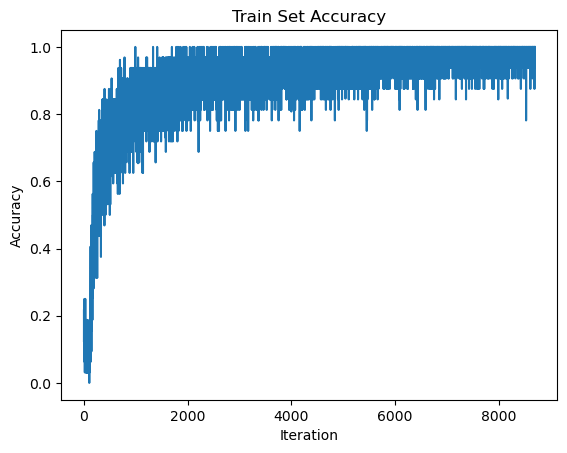

In [21]:
# plot metrics
fig = plt.figure(facecolor="w")
plt.plot(train_acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

### Testing

In [28]:
csnn.eval()

test_acc_hist = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        spk_rec = forward_pass(csnn, data)

        acc = SF.accuracy_rate(spk_rec, targets)
        test_acc_hist.append(acc)

        print(f"Accuracy: {acc * 100:.2f}%")

print("The average accuracy is: ", statistics.mean(test_acc_hist))

Accuracy: 81.25%
Accuracy: 81.25%
Accuracy: 90.62%
Accuracy: 90.62%
Accuracy: 87.50%
Accuracy: 84.38%
Accuracy: 78.12%
Accuracy: 93.75%
Accuracy: 100.00%
Accuracy: 93.75%
Accuracy: 96.88%
Accuracy: 90.62%
Accuracy: 81.25%
Accuracy: 93.75%
Accuracy: 90.62%
Accuracy: 84.38%
Accuracy: 84.38%
Accuracy: 93.75%
Accuracy: 84.38%
Accuracy: 87.50%
Accuracy: 87.50%
Accuracy: 87.50%
Accuracy: 81.25%
Accuracy: 90.62%
Accuracy: 84.38%
Accuracy: 87.50%
Accuracy: 96.88%
Accuracy: 84.38%
Accuracy: 96.88%
Accuracy: 90.62%
Accuracy: 84.38%
Accuracy: 81.25%
Accuracy: 84.38%
Accuracy: 93.75%
Accuracy: 71.88%
Accuracy: 90.62%
Accuracy: 87.50%
Accuracy: 93.75%
Accuracy: 84.38%
Accuracy: 78.12%
Accuracy: 87.50%
Accuracy: 78.12%
Accuracy: 81.25%
Accuracy: 86.67%
The average accuracy is:  0.8726799242424242
